# DATA 320

| Key | Value |
| :------- | :------ |
| Assignment | W7 - Midterm |
| Author | Sara Hodder |
| Date | 11-12-2025 |



---



### **Question**

I'm releasing a movie that could be called Action, Adventure, Thriller, or Sci-Fi.

* How should marketing position the genre to maximize sales?
* How does Metacritic Score influence Sales?
* What's the most profitable month to release the movie?
* Which genre has the highest return on investment (ROI)?



---



In [3]:
# All the installs
!pip install pymongo
!pip install certifi
!pip install pandas
!pip install regex
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 25.5 MB/s eta 0:00:00


In [4]:
# All the imports
import pandas as pd
import re
import pymongo
import certifi
import numpy as np
import statsmodels.formula.api
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns
from datetime import datetime

In [5]:
# Connect to the database using known good certificates
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())
print(f"Using MongoDB version {client.server_info()['version']}.")

# Check what databases exist on this server
all_databases = client.list_database_names()
print(f"This MongoDB server has the databases {all_databases}")

# If we know the correct database to talk to, we connect like this:
my_database = client['MovieDatasets']

# Here is the list of collections within my database
all_collections = my_database.list_collection_names()
print(f"This database has the collections {all_collections}")

Using MongoDB version 8.0.16.
This MongoDB server has the databases ['MovieDatasets', 'admin', 'local']
This database has the collections ['Metacritic', 'IMDB', 'IMDB_Pipeline_View']


In [14]:
# Specify the name of the collection you want to load
collection_name = 'IMDB_Pipeline_View'

# Access the collection from the database
my_collection = my_database[collection_name]

# Query all documents in the collection
cursor = my_collection.find({})

# Convert the cursor to a pandas DataFrame
collection_df = pd.DataFrame(list(cursor))

# Specify the name of the collection you want to load
collection_2_name = 'Metacritic'

# Access the collection from the database
my_2_collection = my_database[collection_2_name]

# Query all documents in the collection
cursor = my_2_collection.find({})

# Convert the cursor to a pandas DataFrame
collection_2_df = pd.DataFrame(list(cursor))

In [15]:
# Connect to the database and verify it's working
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())
db = client['MovieDatasets']
all_collections = db.list_collection_names()
print(f"This database has the collections {all_collections}")

# Find data from IMDB for one particular year using transformed pipeline view
IMDB_Pipeline_View = pd.DataFrame(db.IMDB_Pipeline_View.find({'release_year': 2019}))

# Ensure title column is string and standardize for proper merging
IMDB_Pipeline_View['title'] = IMDB_Pipeline_View['title'].astype(str).str.strip().str.lower()

# Find data from Metacritic for the same year
metacritic_view = pd.DataFrame(db.Metacritic.find({"release_date": re.compile("2019")}))

# Ensure title column is string and standardize for proper merging
metacritic_view['title'] = metacritic_view['title'].astype(str).str.strip().str.lower()

This database has the collections ['Metacritic', 'IMDB', 'IMDB_Pipeline_View']


In [17]:
# Convert Decimal128 to datetime and strings

# Convert Metacritic view to numbers
metacritic_view.score = pd.to_numeric(metacritic_view.score.astype(str), errors='coerce')
metacritic_view.release_date = pd.to_datetime(metacritic_view.release_date.astype(str), errors='coerce')

# Convert IMDB view to numbers
IMDB_Pipeline_View.opening_weekend_sales_usd = pd.to_numeric(IMDB_Pipeline_View.opening_weekend_sales_usd.astype(str), errors='coerce')
IMDB_Pipeline_View.budget_usd = pd.to_numeric(IMDB_Pipeline_View.budget_usd.astype(str), errors='coerce')
IMDB_Pipeline_View.user_rating = pd.to_numeric(IMDB_Pipeline_View.user_rating.astype(str), errors='coerce')
IMDB_Pipeline_View.gross_sales_usd = pd.to_numeric(IMDB_Pipeline_View.gross_sales_usd.astype(str), errors='coerce')
IMDB_Pipeline_View.votes = pd.to_numeric(IMDB_Pipeline_View.votes.astype(str), errors='coerce')

In [18]:
# Merge the two datasets together using an inner join - should produce movies with data on both sides
unified_view = pd.merge(IMDB_Pipeline_View, metacritic_view, on='title', how='inner')
unified_view.head()

,_id_x,budget,cast,certification,company,director,genres,gross_sales,id,opening_weekend,...,is_opening_weekend_sales_usd,opening_weekend_sales_value,opening_weekend_sales_usd,mpaa,_id_y,movie_id,release_date_y,description,score,thumbnail
0,63829636a23f8f7c1acab5ea,"$40,000,000 (estimated)","Daniel Craig, Chris Evans, Ana de Armas, Jamie...",PG-13,"Lionsgate, Media Rights Capital (MRC), T-Street",Rian Johnson,"Comedy, Crime, Drama, Mystery, Thriller","$313,037,496",8946378,None,...,False,None,NaN,PG-13,68f1a79a5364f88b5a732748,21000,2019-11-27,When renowned crime novelist Harlan Thrombey (...,82,https://static.metacritic.com/images/products/...
1,63829639a23f8f7c1acab5eb,"$10,000,000 (estimated)","Florence Pugh, Jack Reynor, Vilhelm Blomgren, ...","TV-MA::(LSV, TV rating), R","A24, B-Reel Films, Nordisk Film, Square Peg",Ari Aster,"Drama, Horror, Mystery, Thriller",None,8772262,"$6,338,935, 07 Jul 2019",...,True,"{'match': '6,338,935', 'idx': 1, 'captures': [...",6338935.0,R,68f1a79a5364f88b5a7327c4,21124,2019-07-03,Dani (Florence Pugh) and Christian (Jack Reyno...,72,https://static.metacritic.com/images/products/...
2,63829641a23f8f7c1acab5ed,"$356,000,000 (estimated)","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",PG-13,"Marvel Studios, Walt Disney Pictures","Anthony Russo, Joe Russo","Action, Adventure, Drama, Sci-Fi","$2,797,800,564",4154796,"$357,115,007, 28 Apr 2019",...,True,"{'match': '357,115,007', 'idx': 1, 'captures':...",357115007.0,PG-13,68f1a79a5364f88b5a73277b,21051,2019-04-26,The grave course of events set in motion by Th...,78,https://static.metacritic.com/images/products/...
3,63829644a23f8f7c1acab5ee,"$55,000,000 (estimated)","Joaquin Phoenix, Robert De Niro, Zazie Beetz, ...",R,"Warner Bros., Village Roadshow Pictures, Villa...",Todd Phillips,"Crime, Drama, Thriller","$1,074,251,311",7286456,"$96,202,337, 06 Oct 2019",...,True,"{'match': '96,202,337', 'idx': 1, 'captures': ...",96202337.0,R,68f1a79a5364f88b5a732872,21298,2019-10-03,Arthur Fleck (Joaquin Phoenix) is struggling t...,59,https://static.metacritic.com/images/products/...
4,6382964aa23f8f7c1acab5f0,None,"Song Kang-ho, Lee Sun-kyun, Cho Yeo-jeong, Cho...",R,"CJ Entertainment, Barunson E&A",Bong Joon Ho,"Drama, Thriller","$269,366,141",6751668,None,...,False,None,NaN,R,68f1a79a5364f88b5a732718,20952,2019-10-11,Meet the Park Family: the picture of aspiratio...,96,https://static.metacritic.com/images/products/...


In [11]:
ols_model = statsmodels.formula.api.ols(
    formula="gross_sales_usd ~ user_rating + budget_usd + opening_weekend_sales_usd + votes + runtime + score",
    data=unified_view).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gross_sales_usd   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     224.3
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           3.01e-30
Time:                        22:53:18   Log-Likelihood:                -967.96
No. Observations:                  49   AIC:                             1950.
Df Residuals:                      42   BIC:                             1963.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [12]:
# A custom formatter for currency
def format_currency(amount, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"

    # Add to charts using currency
    # plt.gca().yaxis.set_major_formatter(format_currency)

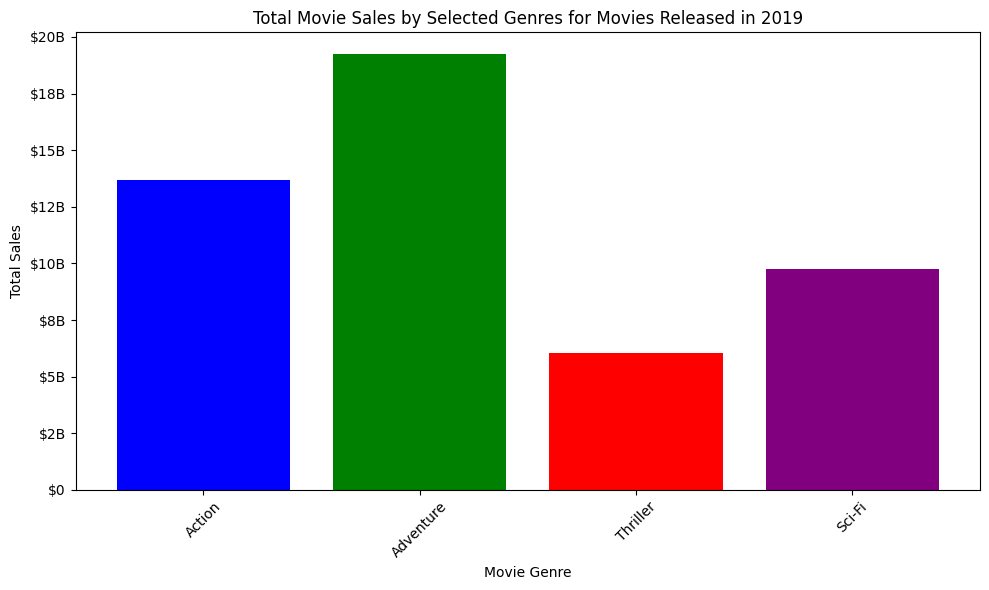

In [13]:
# Define the four genres of interest
target_genres = ["Action", "Adventure", "Thriller", "Sci-Fi"]

# Filter the unified_view DataFrame for movies belonging to the target genres
# and having valid gross_sales_usd.
df_filtered = unified_view[
    unified_view['genres'].notna() &
    (unified_view['genres'].astype(str).str.strip() != '') &
    unified_view['gross_sales_usd'].notna()
].copy()

# Split the 'genres' string into a list and then explode it
df_filtered['genre_list'] = df_filtered['genres'].astype(str).str.split(', ').apply(lambda x: [g.strip() for g in x])
df_exploded_genres = df_filtered.explode('genre_list')

# Filter the exploded DataFrame to include only the target genres
df_target_genres = df_exploded_genres[df_exploded_genres['genre_list'].isin(target_genres)]

# Group by the specific genres and sum 'gross_sales_usd'
grouped_sales = df_target_genres.groupby('genre_list')['gross_sales_usd'].sum().reset_index()

# Sort the DataFrame according to the order in target_genres for consistent plotting
grouped_sales['genre_list'] = pd.Categorical(
    grouped_sales['genre_list'], categories=target_genres, ordered=True
)
grouped_sales = grouped_sales.sort_values('genre_list')

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(grouped_sales['genre_list'], grouped_sales['gross_sales_usd'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Movie Genre")
plt.ylabel("Total Sales")
plt.title("Total Movie Sales by Selected Genres for Movies Released in 2019")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(format_currency)
plt.tight_layout()
plt.show()

### **How should marketing position the genre to maximize sales?**

The Adventure genre has the most sales for the year 2019. This chart indicates that marketing efforts should lead with the Adventure genre to maximize sales. Action should be considered as a secondary genre.

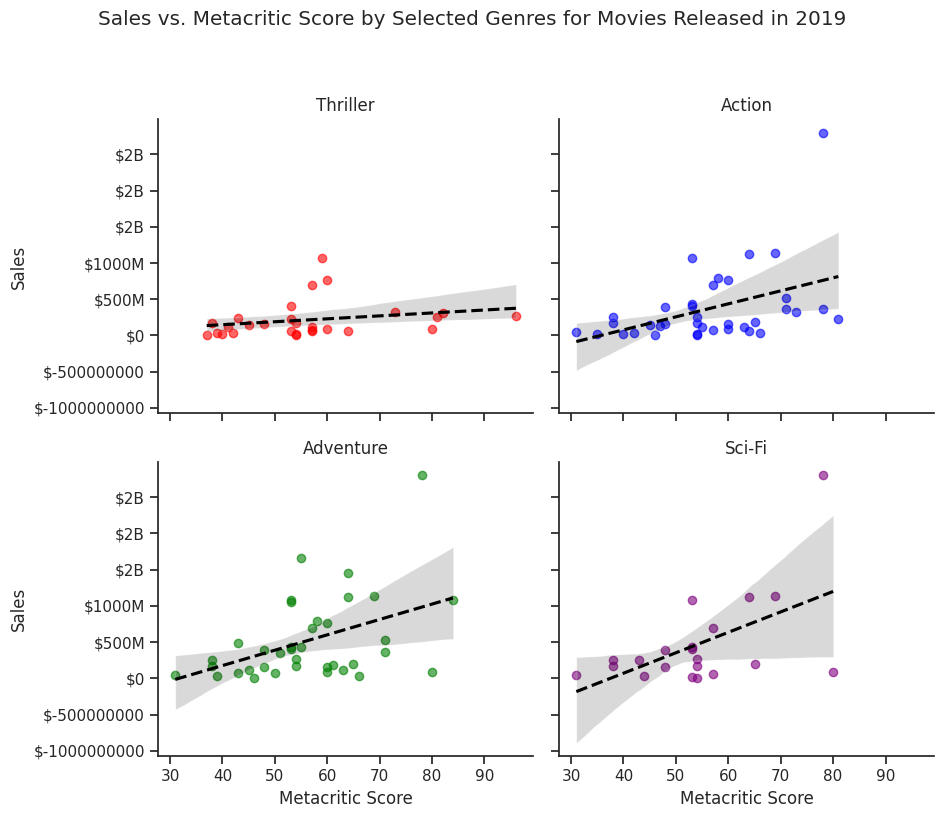

In [ ]:
# Define the four genres of interest
target_genres = ["Action", "Adventure", "Thriller", "Sci-Fi"]

# Filter unified_view for movies with valid gross_sales_usd, budget_usd, score, and genres
plot_df_anscombe = unified_view[
    unified_view['gross_sales_usd'].notna() &
    unified_view['score'].notna() &
    unified_view['genres'].notna() &
    (unified_view['genres'].astype(str).str.strip() != '')
].copy()

# Split the 'genres' string into a list and then explode it
plot_df_anscombe['genre_list'] = plot_df_anscombe['genres'].astype(str).str.split(', ').apply(lambda x: [g.strip() for g in x])
df_exploded_anscombe = plot_df_anscombe.explode('genre_list')

# Filter the exploded DataFrame to include only the target genres
df_filtered_anscombe = df_exploded_anscombe[df_exploded_anscombe['genre_list'].isin(target_genres)]

# Define the custom color palette (re-using the one from the previous scatterplot for consistency)
custom_palette = {
    "Action": "blue",
    "Adventure": "green",
    "Thriller": "red",
    "Sci-Fi": "purple"
}

# Create the lmplot for each genre
g = sns.lmplot(
    data=df_filtered_anscombe,
    x='score',
    y='gross_sales_usd',
    col='genre_list',
    hue='genre_list',
    palette=custom_palette,
    col_wrap=2,
    height=4,
    aspect=1.2,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'black', 'ls':'--'}
)

# Set main title
g.fig.suptitle('Sales vs. Metacritic Score by Selected Genres for Movies Released in 2019', y=1.02)

# Plot the chart
for ax in g.axes.flat:
    current_title = ax.get_title()
    new_title = current_title.replace('genre_list = ', '')
    ax.set_title(new_title)
    ax.set_xlabel('Metacritic Score')
    ax.set_ylabel('Sales')
    ax.yaxis.set_major_formatter(format_currency)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### **How does Metacritic Score influence Sales?**

Overall, it doesn't appear that Metacritic Score has a large influence on profit. The number of movies released appears to be more impactful. For example, Action and Adventure genres have more plot points because there are more movies in those genres released. As the Metacritic Scores average, their profit lines are similar.

The Thriller and Sci-Fi genres release fewer movies, which leads to fewer ratings. The ratings for these genres can vary, which explains why their rating and profit numbers are vastly different. It's more difficult for a Thriller to receive high scores. A Sci-Fi movie has to be very good to achieve higher profit in the Action and Adventure genres.

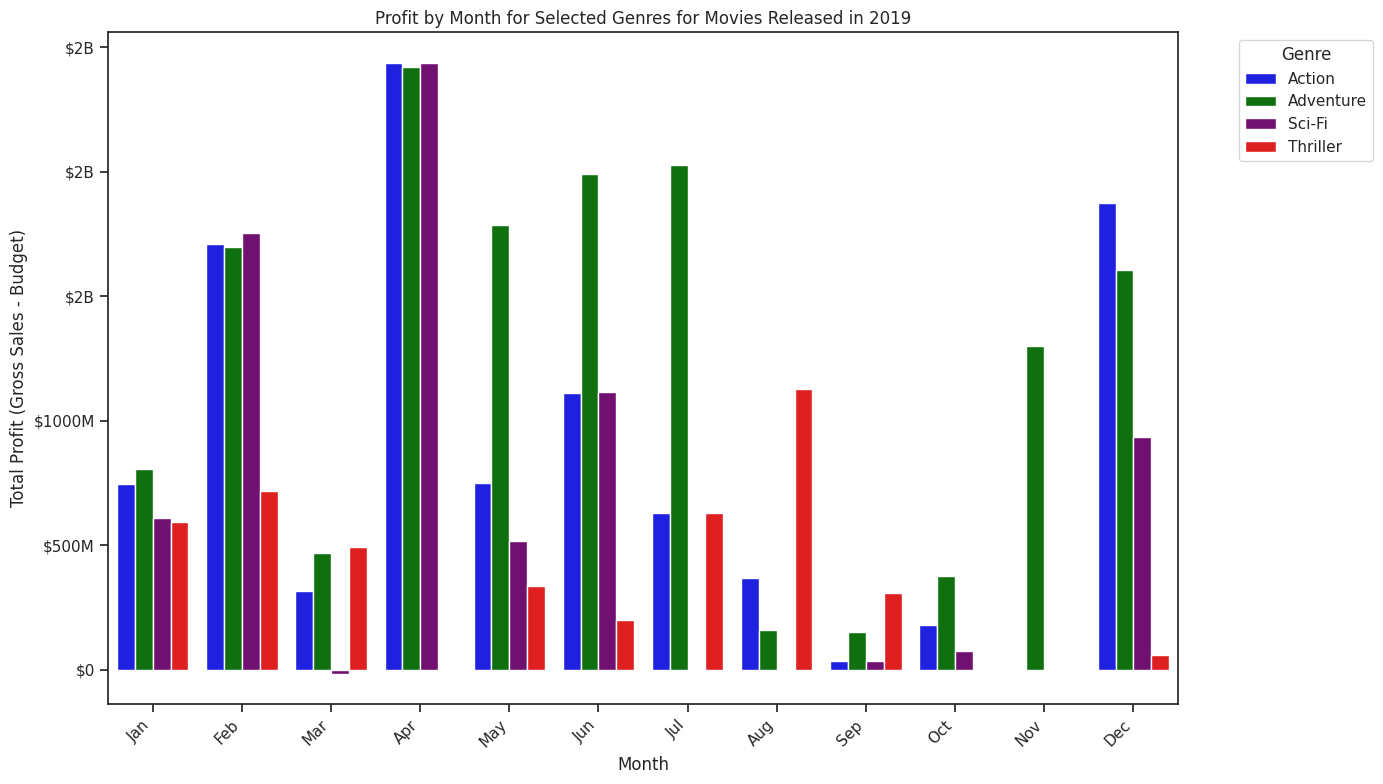

In [ ]:
# Define the four genres of interest
target_genres = ["Action", "Adventure", "Thriller", "Sci-Fi"]

# Filter unified_view for movies with valid gross_sales_usd, budget_usd, release_month, and genres
plot_data_profit = unified_view[
    unified_view['gross_sales_usd'].notna() &
    unified_view['budget_usd'].notna() &
    unified_view['release_month'].notna() &
    unified_view['genres'].notna() &
    (unified_view['genres'].astype(str).str.strip() != '')
].copy()

# Calculate profit
plot_data_profit['profit'] = plot_data_profit['gross_sales_usd'] - plot_data_profit['budget_usd']

# Split the 'genres' string into a list and then explode it
plot_data_profit['genre_list'] = plot_data_profit['genres'].astype(str).str.split(', ').apply(lambda x: [g.strip() for g in x])
df_exploded_profit = plot_data_profit.explode('genre_list')

# Filter the exploded DataFrame to include only the target genres
df_filtered_profit_genres = df_exploded_profit[df_exploded_profit['genre_list'].isin(target_genres)]

# Group by release_year, release_month, and genre, then sum the profit
monthly_genre_profit = df_filtered_profit_genres.groupby(['release_year', 'release_month', 'genre_list'])['profit'].sum().reset_index()

# Create a 'date' column for plotting
monthly_genre_profit['date'] = pd.to_datetime(
    monthly_genre_profit[['release_year', 'release_month']]
    .rename(columns={'release_year': 'year', 'release_month': 'month'})
    .assign(day=1)
)

years_in_data = monthly_genre_profit['release_year'].unique()

plot_df_complete_profit = pd.DataFrame()
for year in years_in_data:
    full_month_dates = pd.to_datetime([f'{year}-{m}-01' for m in range(1, 13)])

    # Create all combinations of months and target genres for the current year
    all_combinations = pd.MultiIndex.from_product([
        full_month_dates, target_genres
    ], names=['date', 'genre_list']).to_frame(index=False)

    # Merge the actual monthly profit data with the full combinations
    year_monthly_profit = monthly_genre_profit[
        monthly_genre_profit['release_year'] == year
    ][['date', 'genre_list', 'profit']]

    complete_year_data = pd.merge(
        all_combinations,
        year_monthly_profit,
        on=['date', 'genre_list'],
        how='left'
    ).fillna(0)

    plot_df_complete_profit = pd.concat([plot_df_complete_profit, complete_year_data])

plot_df_complete_profit = plot_df_complete_profit.sort_values(by=['date', 'genre_list']).reset_index(drop=True)

# Add a column for month names for plotting the x-axis
plot_df_complete_profit['month_name'] = plot_df_complete_profit['date'].dt.strftime('%b')

# Ensure the order of months is correct for plotting
month_order = [datetime(2019, m, 1).strftime('%b') for m in range(1, 13)]
plot_df_complete_profit['month_name'] = pd.Categorical(
    plot_df_complete_profit['month_name'], categories=month_order, ordered=True
)

# Define the custom color palette
custom_palette = {
    "Action": "blue",
    "Adventure": "green",
    "Thriller": "red",
    "Sci-Fi": "purple"
}

# Create the Clustered Bar Chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_df_complete_profit,
    x='month_name',
    y='profit',
    hue='genre_list',
    palette=custom_palette
)

# Plot the chart
plt.title('Profit by Month for Selected Genres for Movies Released in 2019')
plt.xlabel('Month')
plt.ylabel('Total Profit (Gross Sales - Budget)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(format_currency)
plt.tight_layout()
plt.show()

### **What's the most profitable month to release the movie?**

Overall, the spikes for profit align with months where kids are out of school. These are times when kids and families are seeking entertainment.

The most profitable month to release an Action or Adventure movie is in April. Marketing should target students and families who are enjoying Spring Break. Adventure movies see a longer period of profit through the Summer months. These would be the next preferable months if there are production delays.

There are additional spikes in February and December for Action and Adventure movies. If the movie launches in December, marketing should target students and families who are on holiday break. In February, the weather is still cold in February. Marketing should position the movie as a warm, indoor activity.

If the movie is positioned as an Adventure movie, the release should be targeted to April. May, June, and July can be secondary release months.

If the movie is positioned as an Action movie, the release should be targeted to April. December and February can be secondary release months.

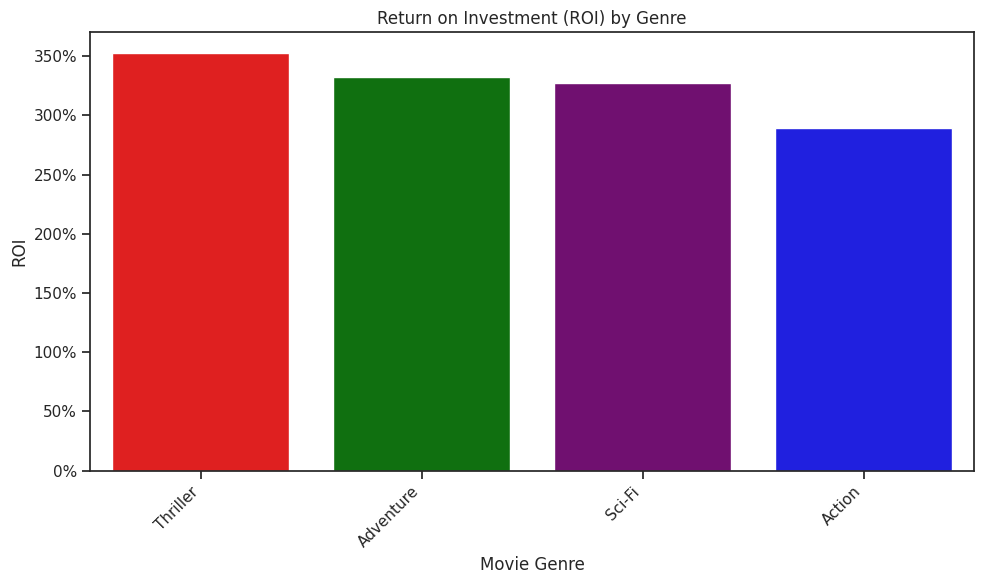

In [ ]:
# Define the four genres of interest
target_genres = ["Action", "Adventure", "Thriller", "Sci-Fi"]

# Filter unified_view for movies with valid gross_sales_usd, budget_usd, and genres
plot_data = unified_view[
    unified_view['gross_sales_usd'].notna() &
    unified_view['budget_usd'].notna() &
    (unified_view['budget_usd'] > 0) & # Ensure budget is greater than 0 to avoid division by zero
    unified_view['genres'].notna() &
    (unified_view['genres'].astype(str).str.strip() != '')
].copy()

# Split the 'genres' string into a list and then explode it
plot_data['genre_list'] = plot_data['genres'].astype(str).str.split(', ').apply(lambda x: [g.strip() for g in x])
df_exploded = plot_data.explode('genre_list')

# Filter the exploded DataFrame to include only the target genres
df_filtered_genres = df_exploded[df_exploded['genre_list'].isin(target_genres)]

# Group by genre and calculate total gross sales and total budget
genre_summary = df_filtered_genres.groupby('genre_list')[['gross_sales_usd', 'budget_usd']].sum().reset_index()

# Calculate ROI for each genre: (Gross Sales - Budget) / Budget
genre_summary['ROI'] = (genre_summary['gross_sales_usd'] - genre_summary['budget_usd']) / genre_summary['budget_usd']

# Sort by ROI for better visualization
genre_summary = genre_summary.sort_values(by='ROI', ascending=False)

# Define the custom color palette (re-using the one from previous charts)
custom_palette = {
    "Action": "blue",
    "Adventure": "green",
    "Thriller": "red",
    "Sci-Fi": "purple"
}

# Create the Bar Chart for ROI
plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_summary,
    x='genre_list',
    y='ROI',
    hue='genre_list', # Added to address FutureWarning
    palette=custom_palette, # Pass the dictionary directly
    legend=False # Set to False as hue is used for the x-axis variable
)

# Plot the chart
plt.title('Return on Investment (ROI) by Genre')
plt.xlabel('Movie Genre')
plt.ylabel('ROI')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Which genre has the highest return on investment (ROI)?**

The ROI for all four genres is pretty close. They all range from 300-350%.

Movies in the Thriller genre have the highest ROI. Adventure movies are a close second.

Action movies have the lowest ROI.


---


## **Summary**

#### **Scenario**

I'm releasing a movie that could be called Action, Adventure, Thriller, or Sci-Fi.

#### **Questions**

* How should marketing position the genre to maximize sales?
* How does Metacritic Score influence Sales?
* What's the most profitable month to release the movie?
* Which genre has the highest return on investment (ROI)?

#### **Answers**

The movie should be positioned primarily as an Adventure movie. This genre showed the best potential for high sales and highest ROI.

While Metacritic Score doesn't appear to directly affect sales, the volume of movies released in the Action and Adventure genres should be taken into account. There will be more competition within those genres. It may be wise to increase marketing budget to increase awareness.

The movie should be targeted to release in April to maximize on Spring Break. If production is delayed, it can also release over the summer months in May, June, or July.